In [8]:
#!gdown --id "1ybKGkc5i3XdI14zlsEziMAVYOVzfvDr6&confirm=t"
#!gdown --id "1vsfryu2rlbNUlXmE2gP8cLXly3zIQUPj&confirm=t"
#!gdown --id "1Ztft_-dTz9FXwiDgMqrHqWDvyd7_Ozfb&confirm=t"
#!unzip results.zip

In [2]:
import torch
import pickle
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score

class CustomDataset(Dataset):
    def __init__(self, data, topics):
        self.data = data
        self.topics = topics

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'data': self.data[idx], 'topic': self.topics[idx]}
        return sample

with open("develop.txt", "r") as f:
    raw_train_data = f.readlines()
train_topics = [i.strip(">\n").split()[2:] for i in raw_train_data[::4]]
with open("topics.txt", "r") as f:
    topics = f.readlines()

topics = topics[::2]
topics = [i.strip() for i in topics]

with open("results.pkl", "rb") as f:
    matrices_result, new_order_names = pickle.load(f)
matrices_result = matrices_result[:, np.newaxis, :, :]


def one_hot_encode(labels, num_classes):
    encoded_labels = np.zeros((len(labels), num_classes))
    for idx, label_list in enumerate(labels):
        for idl, label in enumerate(label_list):
            encoded_labels[idx, idl] = 1
    return encoded_labels


train_topics = one_hot_encode(train_topics, num_classes=9)  # Assuming you have 9 classes

matrices_result = torch.tensor(matrices_result).type(torch.float32).to("cuda:0")
train_topics = torch.tensor(train_topics).type(torch.float32).to("cuda:0")
# Split data into train, validation, and test sets
data_train, data_valtest, topics_train, topics_valtest = train_test_split(matrices_result, train_topics,
                                                                          test_size=0.2,
                                                                          random_state=42)
data_val, data_test, topics_val, topics_test = train_test_split(data_valtest, topics_valtest, test_size=0.5,
                                                                random_state=42)

# Create custom datasets
train_dataset = CustomDataset(data_train, topics_train)
val_dataset = CustomDataset(data_val, topics_val)
test_dataset = CustomDataset(data_test, topics_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv_res = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)  # Removed padding
        self.bn4 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=(2, 4), stride=(2, 4))
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.fc1 = nn.Linear(128 * 1 * 44, 64)  # Reduced fully connected layer size
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        residual = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        x = self.conv3(x)
        x = self.pool(x)
        x = self.bn3(x)

        residual = self.conv_res(residual)
        residual = self.pool(residual)
        x += residual
        x = F.relu(x)

        x = self.conv4(x)
        x = self.pool2(x)
        x = self.bn4(x)
        x = F.relu(x)

        x = x.view(-1, 128 * 1 * 44)
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))  # Sigmoid activation for multi-label classification
        return x

In [13]:

# Initialize the model
model = CNN(num_classes=9).to("cuda:0")

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0  # Initialize training loss
    for batch in train_loader:
        images, labels = batch['data'], batch['topic']
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  # Accumulate training loss

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch['data'], batch['topic']
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs > 0.9).float()  # Thresholding the output probabilities to get binary predictions
            val_total += labels.size(0) * labels.size(1)  # Total number of labels
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {avg_train_loss:.4f}, '
          f'Validation Loss: {avg_val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

# Evaluation
model.eval()
correct = 0
total = 0
all_labels = []
all_outputs = []
all_predicted = []

with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['data'], batch['topic']
        outputs = model(images)
        predicted = (outputs > 0.9).float()  # Thresholding the output probabilities to get binary predictions

        total += labels.size(0) * labels.size(1)  # Total number of labels
        correct += (predicted == labels).sum().item()
        
        all_labels.append(labels.cpu().numpy())
        all_outputs.append(outputs.cpu().numpy())
        all_predicted.append(predicted.cpu().numpy())

all_labels = np.vstack(all_labels)
all_outputs = np.vstack(all_outputs)
all_predicted = np.vstack(all_predicted)

accuracy = 100 * correct / total
auc = roc_auc_score(all_labels, all_outputs, average='micro')
f1 = f1_score(all_labels, all_predicted, average='micro')

print('Accuracy: {:.2f}%'.format(accuracy))
print('AUC: {:.4f}'.format(auc))
print('F1 Score: {:.4f}'.format(f1))


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/2], Training Loss: 0.6642, Validation Loss: 0.6510, Validation Accuracy: 96.91%
Epoch [2/2], Training Loss: 0.6509, Validation Loss: 0.6509, Validation Accuracy: 96.91%
Accuracy: 96.71%
AUC: 0.9468
F1 Score: 0.8712


/home/dsi/vignano/miniconda3/lib/python3.9/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AUC: 0.9468
F1 Score: 0.8712
Classification Report:
              precision    recall  f1-score   support

     Label 0       1.00      1.00      1.00       213
     Label 1       0.00      0.00      0.00        56
     Label 2       0.00      0.00      0.00         6
     Label 3       0.00      0.00      0.00         1
     Label 4       0.00      0.00      0.00         0
     Label 5       0.00      0.00      0.00         0
     Label 6       0.00      0.00      0.00         0
     Label 7       0.00      0.00      0.00         0
     Label 8       0.00      0.00      0.00         0

   micro avg       1.00      0.77      0.87       276
   macro avg       0.11      0.11      0.11       276
weighted avg       0.77      0.77      0.77       276
 samples avg       1.00      0.86      0.91       276



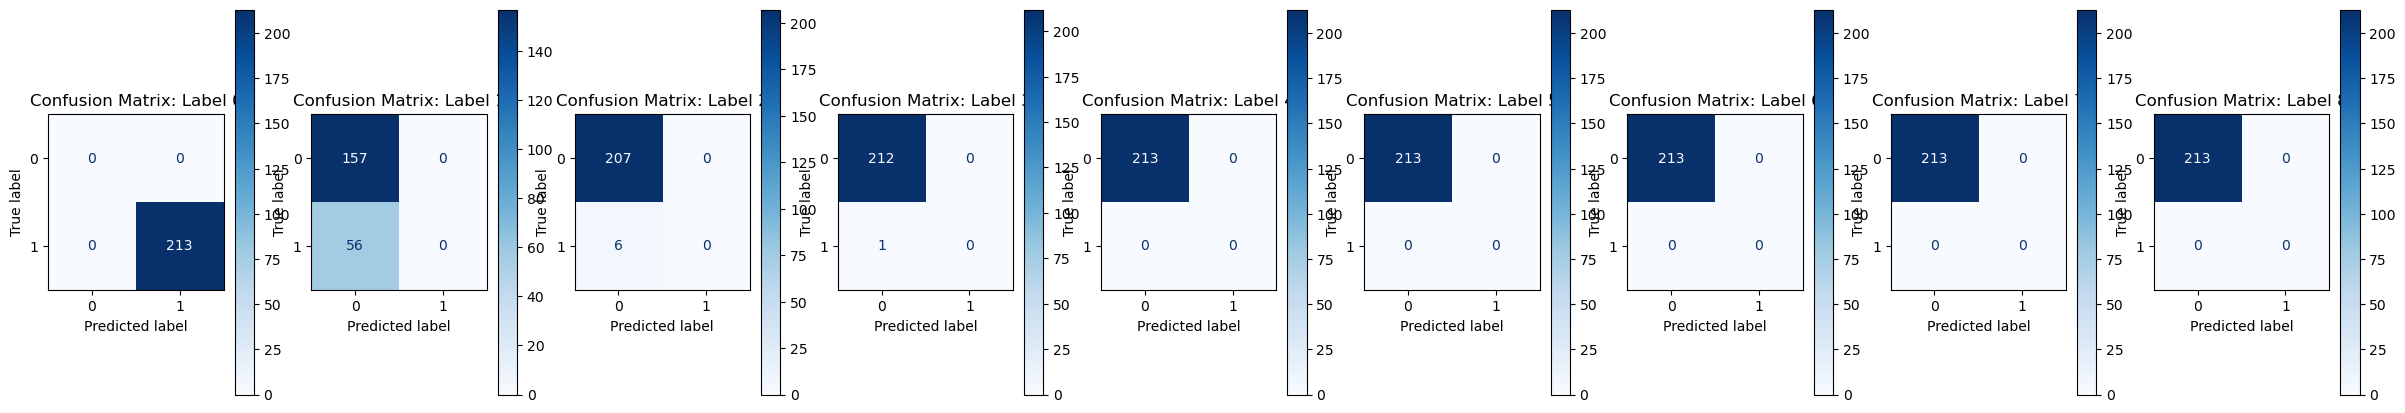

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, roc_auc_score, f1_score, classification_report
import torch

# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []
output_probabilities = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        images, labels = batch['data'], batch['topic']
        outputs = model(images)
        predicted = (outputs > 0.9).int()  # Thresholding the output probabilities to get binary predictions

        # Append true and predicted labels for each data point in the batch
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
        output_probabilities.extend(outputs.cpu().numpy())

# Convert lists to numpy arrays
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
output_probabilities = np.array(output_probabilities)

# Compute multilabel confusion matrix
conf_matrix = multilabel_confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrices for each label
num_labels = true_labels.shape[1]

# Compute AUC for each label
auc = roc_auc_score(true_labels, output_probabilities, average='micro')
print(f'AUC: {auc:.4f}')

# Compute F1 score for each label
f1 = f1_score(true_labels, predicted_labels, average='micro')
print(f'F1 Score: {f1:.4f}')

# Generate a classification report
class_report = classification_report(true_labels, predicted_labels, target_names=[f'Label {i}' for i in range(true_labels.shape[1])], zero_division=0)
print("Classification Report:")
print(class_report)

# Visualize the classification report
from sklearn.metrics import ConfusionMatrixDisplay

# Helper function to plot confusion matrices
def plot_confusion_matrices(conf_matrices, labels):
    n_labels = len(labels)
    fig, axes = plt.subplots(1, n_labels, figsize=(30, 5))
    if n_labels == 1:
        axes = [axes]
    for i, (matrix, label) in enumerate(zip(conf_matrices, labels)):
        disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
        disp.plot(ax=axes[i], values_format='d', cmap='Blues')
        axes[i].set_title(f'Confusion Matrix: {label}')
    plt.show()

# Plot confusion matrices
plot_confusion_matrices(conf_matrix, [f'Label {i}' for i in range(num_labels)])
